**Autora**: Jayne de Morais Silva

**Email**: devjaynemorais@gmail.com

In [1]:
import pandas as pd
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import utils as u
import os
import seaborn as sns
import re #regular expression
import string

# text preprocessing modules
from nltk.tokenize import word_tokenize
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer 
nltk.download('punkt')

from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import cross_val_score, RandomizedSearchCV

from keras.preprocessing.text import Tokenizer
import keras
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

# deep learning libraries for text pre-processing
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
# Modeling 
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, GlobalAveragePooling1D, Dense, Dropout, LSTM, Bidirectional

from sklearn.metrics import (
    accuracy_score,
    classification_report,
    plot_confusion_matrix,
    f1_score,
    roc_auc_score,
)

%matplotlib inline

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\jayne\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\jayne\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [2]:
PATH_PROJECT = './'
PATH_TRAINING_SET = PATH_PROJECT+'TrainingSet/'
PATH_TEST_SET = PATH_PROJECT+'TestSet/'

## Informações importantes

O padrão de rotulação foi definido como `ham` (legítimo) ou` spam`.

O objetivo deste teste é obter um modelo que possa gerenciar corretamente as mensagens recebidas no formato SMS (`ham` ou` spam`). 

Considerando um cenário real, assuma que uma pessoa normal não deseja ver uma mensagem de `spam`. No entanto, eles aceitam se uma mensagem normal (`ham`) às vezes é alocada na caixa de` spam`.

### Resumo do Jupyter Notebook

Neste Jupyter Notebook é realizada:

- Inicialmente uma análise exploratória dos dados, para visualizar quantidades por target e a relação do tamanho do texto do SMS com a variável target;


- É realizada limpeza da base por meio da remoção de espaços em braco, padronização dos caracteres para o formato minúsculo, remoção de quebra de linhas e de pontuação no texto. Iremos deixar os números, pois é possível que em casos de spam, sejam enviados números de telefones e etc;


- Vetorização do texto do SMS em uma sequência de inteiros e transfomar em um dicionário. Posteriormente, cada sequência é transformada em uma lista e depois padronizada no mesmo tamanho;


- É construído um modelo deep learning e treinado com o critério de parada baseado no valor de loss e, avaliado suas métricas;


- Também foi treinado o modelo MultinomialNB (Classificador Naive Bayes para modelos multinomiais) utilizando o RandomizedSearchCV para estimar os melhores parâmetros dentro dos intervalos definidos;


- Após a avaliação de resultados, percebeu-se que o modelo baseado em deep learning apresentou melhores resultados que o MultinomialNB, portanto o mesmo foi utilizado para realizar as predições da submissão, que foi exportada para o arquivo: sms_spam_detection_submission-devjaynemorais.csv.

In [3]:
file = 'sms-hamspam-train.csv'

df_train = pd.read_csv(PATH_TRAINING_SET+file, sep='\t', header=None, names=['target', 'sms_text'])
df_train.head(2)

,target,sms_text
0,ham,"Go until jurong point, crazy.. Available only ..."
1,spam,"SMSSERVICES. for yourinclusive text credits, p..."


## Análise Exploratória de Dados

In [4]:
df_train.isnull().sum()

target      0
sms_text    0
dtype: int64

<AxesSubplot:xlabel='target', ylabel='count'>

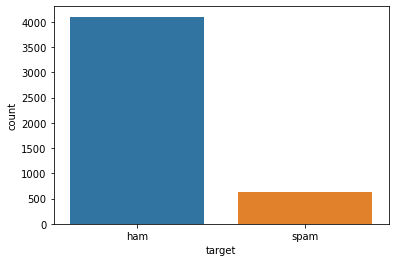

In [5]:
sns.countplot(x ='target', data = df_train)

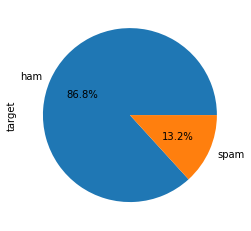

In [6]:
#groupby the data by spam or no spam
data = df_train.groupby("target")["target"].count().plot.pie(autopct="%.1f%%");

Analisaremos a frequência de palavras por sms spam e não spam.

Total words 295693


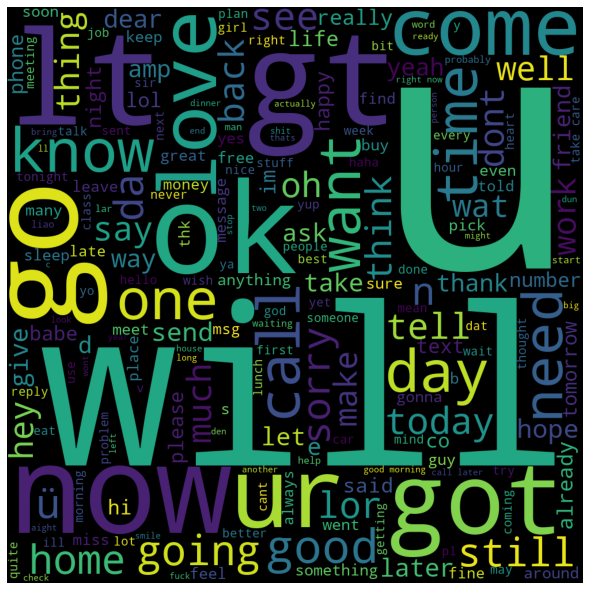

In [7]:
# visualize ham labeled sms
cloud_stopwords = set(STOPWORDS)
ham_words = u.collect_words(df_train, label="ham")

print("Total words {}".format(len(ham_words)))

u.plot_wordcloud(ham_words, cloud_stopwords)

Total words 87251


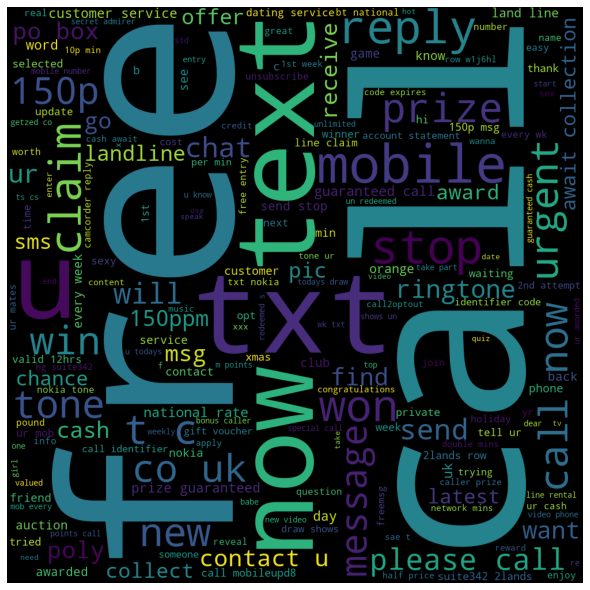

In [8]:
# visualize ham labeled sms
cloud_stopwords = set(STOPWORDS)
ham_words = u.collect_words(df_train, label="spam")

print("Total words {}".format(len(ham_words)))

u.plot_wordcloud(ham_words, cloud_stopwords)


### Tamanho do texto vs target

array([<AxesSubplot:title={'center':'ham'}>,
       <AxesSubplot:title={'center':'spam'}>], dtype=object)

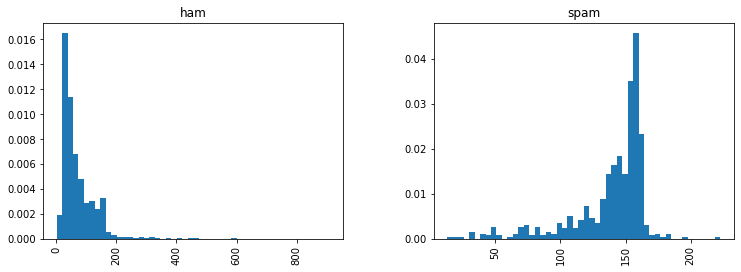

In [9]:
#data = df_train.copy()
df_train['length_text'] = df_train['sms_text'].apply(len)

df_train.hist(column = 'length_text', by ='target', figsize=(12,4), bins = 50, density=True)


## Preparação dos Dados

In [10]:
df_train.head(3)

,target,sms_text,length_text
0,ham,"Go until jurong point, crazy.. Available only ...",111
1,spam,"SMSSERVICES. for yourinclusive text credits, p...",156
2,spam,25p 4 alfie Moon's Children in need song on ur...,161


### Limpeza dos Dados

In [11]:
def data_clean(df):
    
    #Remove spaces at the beginning and at the end of the string
    df['sms_text'] = df['sms_text'].str.strip()
    
    #converts all uppercase characters in a string into lowercase
    df['sms_text'] = df['sms_text'].str.lower()
    
    #remove elements '\n'
    df['sms_text'] = df['sms_text'].str.replace('\n','')
    
    #remove punctuation of the string
    df['sms_text'] = df['sms_text'].str.translate(str.maketrans(dict.fromkeys(string.punctuation)))
    
    return df

In [12]:
df_train = data_clean(df_train)

df_train.head(2)

,target,sms_text,length_text
0,ham,go until jurong point crazy available only in ...,111
1,spam,smsservices for yourinclusive text credits pls...,156


### Tratamento da variável target

In [13]:
df_train['target'] = df_train['target'].map({'ham': 0, 'spam': 1})

In [14]:
df_train

,target,sms_text,length_text
0,0,go until jurong point crazy available only in ...,111
1,1,smsservices for yourinclusive text credits pls...,156
2,1,25p 4 alfie moons children in need song on ur ...,161
3,1,u have a secret admirer reveal who thinks u r ...,147
4,1,dear voucher holder to claim this weeks offer ...,152
...,...,...,...
4720,1,this is the 2nd time we have tried 2 contact u...,160
4721,0,will ü b going to esplanade fr home,36
4722,0,pity was in mood for that soany other suggest...,57
4723,0,the guy did some bitching but i acted like id ...,125


### Bases de Treino e Teste

In [15]:
# split data into train and test
X_train, X_test, y_train, y_test = train_test_split(
    df_train["sms_text"],
    df_train["target"],
    test_size=0.15,
    random_state=0,
    shuffle=True,
    stratify=df_train["target"],
)

In [16]:
## Balanceam}ento

In [17]:
#ham_msg_df = X_train.loc[X_train['target']=='ham'].sample(n = len(y_train.value_counts()['spam']), random_state = 44)
#spam_msg_df = spam_msg
#print(ham_msg_df.shape, spam_msg_df.shape)

In [18]:
#rus = RandomUnderSampler(random_state=42)
#X_train, y_train = rus.fit_sample(X_train, y_train)


In [19]:
X_train

483                          good morning plz call me sir
3689             normally i use to drink more water daily
153     please call our customer service representativ...
905          jus came back fr lunch wif my sis only u leh
1270    u can win £100 of music gift vouchers every we...
                              ...                        
2850              sbut he had some luck2 catches put down
3973               im good i have been thinking about you
4478    gal n boy walking in d park galcan i hold ur h...
3372    u free on sat rite u wan 2 watch infernal affa...
3791    of course i guess gods just got me on hold rig...
Name: sms_text, Length: 4016, dtype: object

## Pre-processamento

In [20]:

# Defining pre-processing hyperparameters
max_len = 50 
trunc_type = "post" 
padding_type = "post" 
oov_tok = "<OOV>" #if given, it will be added to word_index and used to replace out-of-vocabulary words during text_to_sequence calls
vocab_size = 500


#Tokenizer: This class allows to vectorize a text corpus, by turning each text into either a sequence of integers
tokenizer = Tokenizer(num_words = vocab_size, char_level=False, oov_token = oov_tok)
tokenizer.fit_on_texts(X_train)

In [21]:
#dictionary words
word_index = tokenizer.word_index
word_index

{'<OOV>': 1,
 'to': 2,
 'i': 3,
 'you': 4,
 'a': 5,
 'the': 6,
 'u': 7,
 'and': 8,
 'is': 9,
 'in': 10,
 'me': 11,
 'my': 12,
 'for': 13,
 'your': 14,
 'it': 15,
 'of': 16,
 'call': 17,
 'have': 18,
 'on': 19,
 '2': 20,
 'that': 21,
 'now': 22,
 'are': 23,
 'im': 24,
 'but': 25,
 'not': 26,
 'so': 27,
 'can': 28,
 'at': 29,
 'do': 30,
 'be': 31,
 'get': 32,
 'will': 33,
 'ur': 34,
 'or': 35,
 'if': 36,
 'with': 37,
 'we': 38,
 'just': 39,
 'this': 40,
 'no': 41,
 'its': 42,
 'up': 43,
 '4': 44,
 'dont': 45,
 'when': 46,
 'from': 47,
 'ltgt': 48,
 'what': 49,
 'go': 50,
 'free': 51,
 'all': 52,
 'ok': 53,
 'how': 54,
 'know': 55,
 'come': 56,
 'got': 57,
 'ill': 58,
 'out': 59,
 'then': 60,
 'like': 61,
 'was': 62,
 'only': 63,
 'good': 64,
 'am': 65,
 'time': 66,
 'love': 67,
 'day': 68,
 'text': 69,
 'want': 70,
 'send': 71,
 'one': 72,
 'ü': 73,
 'he': 74,
 'as': 75,
 'home': 76,
 'there': 77,
 'see': 78,
 'lor': 79,
 'r': 80,
 'back': 81,
 'need': 82,
 'by': 83,
 'going': 84,
 'our'

In [22]:
# check how many words 
tot_words = len(word_index)
print('{} unique tokens. '.format(tot_words))

8055 unique tokens. 


In [23]:
# Sequencing and padding on training and testing 

#Transforms each sequence into a list of text.
training_sequences = tokenizer.texts_to_sequences(X_train) 

#Pads sequences to the same length.
training_padded = pad_sequences(training_sequences, maxlen = max_len, padding = padding_type, truncating = trunc_type )
training_sequences


[[64, 187, 1, 17, 11, 372],
 [1, 3, 243, 2, 1, 127, 1, 1],
 [107,
  17,
  85,
  238,
  227,
  1,
  19,
  1,
  1,
  1,
  1,
  411,
  1,
  75,
  4,
  18,
  175,
  5,
  249,
  446,
  169,
  35,
  495,
  144],
 [412, 425, 81, 1, 328, 447, 12, 1, 63, 7, 355],
 [7,
  28,
  176,
  426,
  16,
  448,
  390,
  1,
  188,
  126,
  1,
  22,
  86,
  6,
  373,
  264,
  2,
  1,
  1,
  1,
  1,
  1,
  1,
  1],
 [190,
  14,
  95,
  132,
  122,
  106,
  374,
  37,
  5,
  391,
  144,
  249,
  17,
  1,
  47,
  1,
  285,
  123,
  1,
  1,
  1,
  63],
 [64,
  1,
  12,
  67,
  54,
  23,
  96,
  3,
  133,
  14,
  64,
  8,
  413,
  18,
  108,
  1,
  3,
  449,
  8,
  170,
  4,
  177,
  5,
  1,
  356,
  47,
  1,
  6,
  1],
 [51, 1, 1, 1, 2, 496, 1, 307, 126, 1, 1, 2, 1, 244, 1, 1],
 [190,
  497,
  1,
  13,
  1,
  1,
  96,
  9,
  14,
  1,
  68,
  20,
  183,
  59,
  184,
  1,
  1,
  1,
  77,
  9,
  5,
  1,
  1,
  1,
  4],
 [10, 1, 25, 498, 275, 7, 308, 307, 79],
 [289, 1, 343],
 [60, 32, 108, 169, 427, 8, 58, 69, 1],

In [24]:
training_padded

array([[ 64, 187,   1, ...,   0,   0,   0],
       [  1,   3, 243, ...,   0,   0,   0],
       [107,  17,  85, ...,   0,   0,   0],
       ...,
       [  1,  89, 327, ...,   0,   0,   0],
       [  7,  51,  19, ...,   0,   0,   0],
       [ 16,   1,   3, ...,   0,   0,   0]])

In [25]:
testing_sequences = tokenizer.texts_to_sequences(X_test)
testing_padded = pad_sequences(testing_sequences, maxlen = max_len,
padding = padding_type, truncating = trunc_type)

In [26]:
# Shape of train tensor
print(training_padded.shape)
print(testing_padded.shape)

(4016, 50)
(709, 50)


# Modelagem

## Deep Learning

In [27]:
vocab_size = 500 # As defined earlier
embeding_dim = 16
drop_value = 0.2 # dropout
n_dense = 24

#Below is a model architecture of dense spam detection model.
#Dense model architecture
model = Sequential()

#Turns positive integers (indexes) into dense vectors of fixed size.
model.add(Embedding(vocab_size, embeding_dim, input_length=max_len))

model.add(GlobalAveragePooling1D())
model.add(Dense(24, activation='relu'))
model.add(Dropout(drop_value))
model.add(Dense(1, activation='sigmoid'))

In [28]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 50, 16)            8000      
_________________________________________________________________
global_average_pooling1d (Gl (None, 16)                0         
_________________________________________________________________
dense (Dense)                (None, 24)                408       
_________________________________________________________________
dropout (Dropout)            (None, 24)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 25        
Total params: 8,433
Trainable params: 8,433
Non-trainable params: 0
_________________________________________________________________


In [29]:
#model compile
model.compile(loss='binary_crossentropy',optimizer='adam' ,metrics=['accuracy'])

In [30]:
# fitting a dense spam detector model
num_epochs = 50

#defined stop criterion
early_stop = EarlyStopping(monitor='val_loss', patience=3)
history = model.fit(training_padded, y_train, epochs=num_epochs, validation_data=(testing_padded, y_test),callbacks =[early_stop], verbose=2)

Epoch 1/50
126/126 - 0s - loss: 0.5332 - accuracy: 0.8541 - val_loss: 0.3702 - val_accuracy: 0.8674
Epoch 2/50
126/126 - 0s - loss: 0.3254 - accuracy: 0.8678 - val_loss: 0.2799 - val_accuracy: 0.8660
Epoch 3/50
126/126 - 0s - loss: 0.2365 - accuracy: 0.8875 - val_loss: 0.1897 - val_accuracy: 0.9238
Epoch 4/50
126/126 - 0s - loss: 0.1670 - accuracy: 0.9455 - val_loss: 0.1427 - val_accuracy: 0.9506
Epoch 5/50
126/126 - 0s - loss: 0.1277 - accuracy: 0.9602 - val_loss: 0.1129 - val_accuracy: 0.9591
Epoch 6/50
126/126 - 0s - loss: 0.1025 - accuracy: 0.9674 - val_loss: 0.0956 - val_accuracy: 0.9704
Epoch 7/50
126/126 - 0s - loss: 0.0873 - accuracy: 0.9719 - val_loss: 0.0869 - val_accuracy: 0.9718
Epoch 8/50
126/126 - 0s - loss: 0.0770 - accuracy: 0.9744 - val_loss: 0.0778 - val_accuracy: 0.9760
Epoch 9/50
126/126 - 0s - loss: 0.0698 - accuracy: 0.9783 - val_loss: 0.0731 - val_accuracy: 0.9760
Epoch 10/50
126/126 - 0s - loss: 0.0621 - accuracy: 0.9798 - val_loss: 0.0724 - val_accuracy: 0.9803

In [31]:
# Model performance on test data 
model.evaluate(testing_padded, y_test)

23/23 [==============================] - 0s 607us/step - loss: 0.0691 - accuracy: 0.9803


[0.069071464240551, 0.9802538752555847]

In [32]:
# Read as a dataframe 
metrics = pd.DataFrame(history.history)

# Rename columns
metrics.rename(columns = {'loss': 'Training_Loss', 'accuracy': 'Training_Accuracy', 'val_loss': 'Validation_Loss', 'val_accuracy': 'Validation_Accuracy'}, inplace = True)
def plot_graphs(var1, var2, string):
    metrics[[var1, var2]].plot()
    plt.title('Training and Validation ' + string)
    plt.xlabel ('Number of epochs')
    plt.ylabel(string)
    plt.legend([var1, var2])

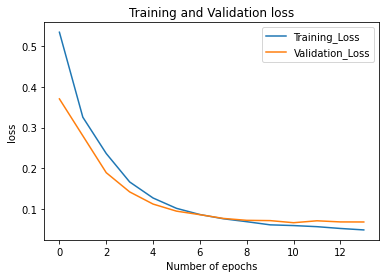

In [33]:
plot_graphs('Training_Loss', 'Validation_Loss', 'loss')

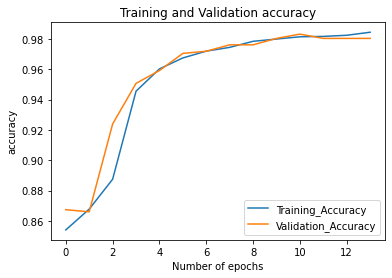

In [34]:
plot_graphs('Training_Accuracy', 'Validation_Accuracy', 'accuracy')


In [35]:
#Probability values of the predictions made in the last layer of the neural network

y_pred = model.predict(testing_padded)
y_pred= np.ravel(y_pred).tolist()
y_pred

[0.005860120058059692,
 0.9766647219657898,
 0.00302007794380188,
 0.003019094467163086,
 0.015732377767562866,
 0.002659916877746582,
 0.0020474791526794434,
 0.04374194145202637,
 0.001422286033630371,
 0.004497259855270386,
 0.0002967715263366699,
 0.9761803150177002,
 0.05733850598335266,
 0.0002803802490234375,
 9.692839375929907e-05,
 0.9976584911346436,
 0.0014845430850982666,
 0.01361459493637085,
 0.7566220164299011,
 0.016145914793014526,
 0.0005851984024047852,
 0.0010592341423034668,
 0.1644185483455658,
 0.0004048347473144531,
 3.3968168281717226e-05,
 0.0010903775691986084,
 0.0001907944679260254,
 0.0002232193946838379,
 5.2156319725327194e-05,
 0.0020175278186798096,
 0.0015295445919036865,
 0.01387760043144226,
 0.007044970989227295,
 0.00010190396278630942,
 0.15553733706474304,
 0.004273593425750732,
 0.004137784242630005,
 0.001283109188079834,
 0.004750639200210571,
 0.001099705696105957,
 0.0017951726913452148,
 0.0019288063049316406,
 0.002888500690460205,
 0.002

In [36]:
#Transform probability values into categorical labels with the 50% threshold

df_f = pd.DataFrame(columns=['sms_text'])
df_f['sms_text'] = X_test

df_f['y_pred'] = y_pred
df_f['predict'] = df_f['y_pred'].apply(lambda x: 0 if x <= 0.50 else 1) 
df_f

,sms_text,y_pred,predict
2813,well then you have a great weekend,0.005860,0
1732,u are subscribed to the best mobile content se...,0.976665,1
2477,nope juz off from work,0.003020,0
4450,my darling sister how are you doing whens scho...,0.003019,0
3783,got hella gas money want to go on a grand natu...,0.015732,0
...,...,...,...
4339,i uploaded mine to facebook,0.004846,0
593,yagoing for restaurant,0.010508,0
3255,u have a secret admirer who is looking 2 make ...,0.958267,1
200,i walked an hour 2 c u doesnt that show i car...,0.000889,0


In [37]:
#Metrics
print(classification_report(y_test, df_f['predict']))

              precision    recall  f1-score   support

           0       0.98      1.00      0.99       615
           1       0.97      0.88      0.92        94

    accuracy                           0.98       709
   macro avg       0.97      0.94      0.96       709
weighted avg       0.98      0.98      0.98       709



In [38]:
"""
# Transform text data 
vectorizer = CountVectorizer(lowercase=False)
vectorizer.fit(X_train)

#transform train/test data 
X_train_trans = vectorizer.transform(X_train)
X_test_trans = vectorizer.transform(X_test)

print(X_train_trans)"""

'\n# Transform text data \nvectorizer = CountVectorizer(lowercase=False)\nvectorizer.fit(X_train)\n\n#transform train/test data \nX_train_trans = vectorizer.transform(X_train)\nX_test_trans = vectorizer.transform(X_test)\n\nprint(X_train_trans)'

## MultinomialNB

In [39]:
spam_classifier = MultinomialNB()


In [40]:
scores = cross_val_score(spam_classifier,
                         training_padded,
                         y_train,
                         cv=10,
                         verbose=3,
                         n_jobs=-1)


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of  10 | elapsed:    3.3s remaining:    7.8s
[Parallel(n_jobs=-1)]: Done   7 out of  10 | elapsed:    3.3s remaining:    1.3s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    3.4s finished


In [41]:
scores.mean()


0.7786323991017481

In [42]:
distribution = {"alpha": [1, 0.1, 0.01, 0.001, 0.0001, 0, 0.2, 0.3]}

grid = RandomizedSearchCV(
    spam_classifier,
    param_distributions=distribution,
    n_jobs=-1,
    cv=10,
    n_iter=20,
    random_state=42,
    return_train_score=True,
    verbose=2,
)

In [43]:
grid.fit(training_padded, y_train)

C:\Users\jayne\anaconda3\envs\basic\lib\site-packages\sklearn\model_selection\_search.py:278: UserWarning: The total space of parameters 8 is smaller than n_iter=20. Running 8 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 10 folds for each of 8 candidates, totalling 80 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:    0.2s finished
C:\Users\jayne\anaconda3\envs\basic\lib\site-packages\sklearn\naive_bayes.py:511: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn('alpha too small will result in numeric errors, '


RandomizedSearchCV(cv=10, estimator=MultinomialNB(), n_iter=20, n_jobs=-1,
                   param_distributions={'alpha': [1, 0.1, 0.01, 0.001, 0.0001,
                                                  0, 0.2, 0.3]},
                   random_state=42, return_train_score=True, verbose=2)

In [44]:
multiNB = MultinomialNB(alpha=grid.best_params_['alpha'])

In [45]:
multiNB.fit(training_padded,y_train)

C:\Users\jayne\anaconda3\envs\basic\lib\site-packages\sklearn\naive_bayes.py:511: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn('alpha too small will result in numeric errors, '


MultinomialNB(alpha=0)

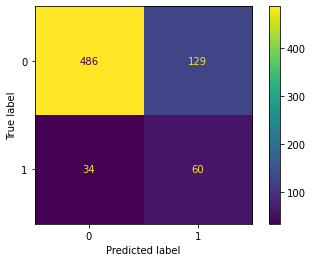

In [46]:
plot_confusion_matrix(multiNB, testing_padded, y_test, normalize=None)

In [47]:
y_pred = multiNB.predict(testing_padded)
y_pred

array([0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1,
       0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0,
       0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0,
       1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0,
       1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [48]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.93      0.79      0.86       615
           1       0.32      0.64      0.42        94

    accuracy                           0.77       709
   macro avg       0.63      0.71      0.64       709
weighted avg       0.85      0.77      0.80       709



## Submissão

In [49]:
file = 'sms-hamspam-test.csv'

df_test = pd.read_csv(PATH_TEST_SET+file, sep='\n', header=None, names=['sms_text'])
df_test.head(2)

,sms_text
0,I know that my friend already told that.
1,It took Mr owl 3 licks


### Pre processamento

In [50]:
df_test = data_clean(df_test)
df_test

,sms_text
0,i know that my friend already told that
1,it took mr owl 3 licks
2,dunno y u ask me
3,kkadvance happy pongal
4,i know but you need to get hotel now i just go...
...,...
842,booked ticket for pongal
843,yes it completely in out of formclark also utt...
844,yeah sure give me a couple minutes to track do...
845,he is there you call and meet him


In [51]:
df_test['length_text'] = df_test['sms_text'].apply(len)
df_test.shape

(847, 2)

In [52]:
df_test

,sms_text,length_text
0,i know that my friend already told that,39
1,it took mr owl 3 licks,22
2,dunno y u ask me,16
3,kkadvance happy pongal,22
4,i know but you need to get hotel now i just go...,146
...,...,...
842,booked ticket for pongal,24
843,yes it completely in out of formclark also utt...,54
844,yeah sure give me a couple minutes to track do...,58
845,he is there you call and meet him,33


In [53]:
# Defining pre-processing hyperparameters
max_len = 50 
trunc_type = "post" 
padding_type = "post" 
oov_tok = "<OOV>" #if given, it will be added to word_index and used to replace out-of-vocabulary words during text_to_sequence calls
vocab_size = 500


#Tokenizer: This class allows to vectorize a text corpus, by turning each text into either a sequence of integers
tokenizer = Tokenizer(num_words = vocab_size, char_level=False, oov_token = oov_tok)
tokenizer.fit_on_texts(df_test["sms_text"])


In [54]:

#dictionary words
word_index = tokenizer.word_index
word_index


{'<OOV>': 1,
 'you': 2,
 'i': 3,
 'to': 4,
 'a': 5,
 'the': 6,
 'u': 7,
 'and': 8,
 'in': 9,
 'my': 10,
 'is': 11,
 'me': 12,
 'for': 13,
 'your': 14,
 'have': 15,
 'of': 16,
 'on': 17,
 'call': 18,
 'that': 19,
 'are': 20,
 'it': 21,
 'so': 22,
 'now': 23,
 'or': 24,
 'not': 25,
 'im': 26,
 'with': 27,
 'but': 28,
 'just': 29,
 'be': 30,
 '2': 31,
 'will': 32,
 'at': 33,
 'if': 34,
 'get': 35,
 'can': 36,
 'ur': 37,
 'do': 38,
 'no': 39,
 'out': 40,
 'we': 41,
 'free': 42,
 'this': 43,
 'like': 44,
 'all': 45,
 'when': 46,
 '4': 47,
 'its': 48,
 'go': 49,
 'up': 50,
 'dont': 51,
 'ok': 52,
 'am': 53,
 'know': 54,
 'got': 55,
 'there': 56,
 'as': 57,
 'ill': 58,
 'from': 59,
 'ltgt': 60,
 'how': 61,
 'send': 62,
 'text': 63,
 'then': 64,
 'good': 65,
 'want': 66,
 'txt': 67,
 'was': 68,
 'time': 69,
 'sorry': 70,
 'day': 71,
 'he': 72,
 'what': 73,
 'come': 74,
 'only': 75,
 'been': 76,
 'by': 77,
 'going': 78,
 'hi': 79,
 'our': 80,
 'love': 81,
 'reply': 82,
 'about': 83,
 'stop': 84

In [55]:

# check how many words 
tot_words = len(word_index)
print('{} unique tokens. '.format(tot_words))

3131 unique tokens. 


In [56]:
submisson_sequences = tokenizer.texts_to_sequences(df_test["sms_text"])
submission_padded = pad_sequences(submisson_sequences, maxlen = max_len,
padding = padding_type, truncating = trunc_type)

print(submission_padded.shape)

(847, 50)


### Predicts

In [57]:
#Probability values of the predictions made in the last layer of the neural network

y_pred = model.predict(submission_padded)
y_pred = np.ravel(y_pred).tolist()
y_pred

[0.0011358559131622314,
 0.004754096269607544,
 0.0005938112735748291,
 0.003539562225341797,
 0.00046691298484802246,
 0.0006836056709289551,
 0.0004284083843231201,
 0.005848526954650879,
 0.015062958002090454,
 0.0006796419620513916,
 0.006776094436645508,
 0.0034453868865966797,
 0.002460181713104248,
 0.16810229420661926,
 0.0007876455783843994,
 0.003771752119064331,
 0.03817892074584961,
 0.0003822147846221924,
 0.0005916059017181396,
 0.014133065938949585,
 0.010766834020614624,
 0.8498594760894775,
 0.6467486619949341,
 0.0004343688488006592,
 0.00038251280784606934,
 0.04076337814331055,
 0.0035611391067504883,
 0.006346702575683594,
 0.0004940927028656006,
 0.00747409462928772,
 0.05548277497291565,
 0.022403478622436523,
 0.8866631984710693,
 0.0007442831993103027,
 0.0025305449962615967,
 0.005862921476364136,
 0.0023054778575897217,
 0.00028258562088012695,
 0.043611496686935425,
 0.006164968013763428,
 0.0032117068767547607,
 0.0046807825565338135,
 0.0013975799083709717

In [58]:
len(y_pred)

847

In [59]:
#Transform probability values into categorical labels with the 50% threshold

df_f = pd.DataFrame(columns=['sms_text'])
df_f['sms_text'] = df_test["sms_text"]

df_f['y_pred'] = y_pred
df_f['predict'] = df_f['y_pred'].apply(lambda x: 0 if x <= 0.50 else 1) 
df_f

,sms_text,y_pred,predict
0,i know that my friend already told that,0.001136,0
1,it took mr owl 3 licks,0.004754,0
2,dunno y u ask me,0.000594,0
3,kkadvance happy pongal,0.003540,0
4,i know but you need to get hotel now i just go...,0.000467,0
...,...,...,...
842,booked ticket for pongal,0.014435,0
843,yes it completely in out of formclark also utt...,0.003961,0
844,yeah sure give me a couple minutes to track do...,0.002516,0
845,he is there you call and meet him,0.001361,0


Apresentando quantidades previstas por label.

In [60]:
df_f['predict'] = df_f['predict'].map({0: 'ham', 1: 'spam'})

<AxesSubplot:xlabel='predict', ylabel='count'>

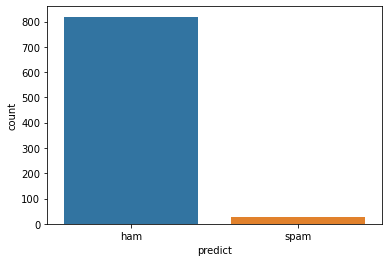

In [61]:
sns.countplot(x ='predict', data = df_f)

In [62]:
#Generating submission file
df_f[['predict', 'sms_text']].to_csv('sms_spam_detection_submission-devjaynemorais.csv', sep=' ', header=None, index=False)

### Referências

https://github.com/Davisy/SMS-Spam-Text-Classification/blob/master/notebook/Spam%20Text%20Message%20Classification%20using%20NLP.ipynb

https://github.com/huai99/Email-Spam-Detection-Python/blob/master/Email%20Spamming%20(Medium%20Part%201).ipynb

https://towardsdatascience.com/how-to-identify-spam-using-natural-language-processing-nlp-af91f4170113

https://towardsdatascience.com/nlp-spam-detection-in-sms-text-data-using-deep-learning-b8632db85cc8
    